# Introduction

Explorations into the newer versions of Keras, TF, and Python 3

**Authors**
- Eric Carlson

In [1]:
from datetime import datetime
import configparser
import hashlib
from importlib import reload
import logging
import numpy as np
import os
import pandas as pd
import pathlib as pl
import sys
import yaml

from IPython import display

import etc_utils as eu

In [2]:
importlib.reload(eu)
#%cat etc_utils.py

<module 'etc_utils' from '/net/home/p2016-090/home/ecarlson/Notebooks/deep-learning/etc_utils.py'>

In [3]:
sys.version

'3.4.5 | packaged by conda-forge | (default, Sep  8 2016, 14:22:44) \n[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]'

## Configure pandas and matplot lib for nice web printing

In [4]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 100

In [5]:
%matplotlib inline

## Load config files, configure logging

In [6]:
work_desc = "deep_learning_intro"

In [7]:
time_str, path_config, creds = eu.load_config_v2()
print('Time string: {}'.format(time_str))

print('Paths:')
for k, item in path_config.items():
    print('{}: {}'.format(k, item))

Time string: 2017-06-17-18-38
Paths:
results_dir: /net/home/310114316/results/deep_learning
input_dir: /net/home/310114316/data/deep_learning
repo_data_dir: ./
log_dir: /net/home/310114316/logs/deep_learning


In [8]:
logger = logging.getLogger()

eu.configure_logging(logger, work_desc=work_desc, log_directory=path_config['log_dir'], time_str=time_str)

Logging to /net/home/310114316/logs/deep_learning/2017-06-17-18-38_deep_learning_intro.log


In [9]:
[k for k in creds.keys()]

['mimic3_v1_4', 'postgres', 'mimic2_v2_6']

In [10]:
[k for k in creds['mimic3_v1_4'].keys()]

['password', 'hostname', 'sa_driver', 'username', 'dbname']

# Load Keras and Test GPU

In [11]:
import tensorflow as tf
from tensorflow.python.client import device_lib

In [12]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [13]:
get_available_gpus()

['/gpu:0']

In [14]:
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17522632163924398466, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 986775552
 locality {
   bus_id: 1
 }
 incarnation: 3114684901701903426
 physical_device_desc: "device: 0, name: Tesla M40 24GB, pci bus id: 0000:00:06.0"]

In [15]:
import keras

Using TensorFlow backend.


In [16]:
keras.__version__

'2.0.4'

In [17]:
tf.__version__

'1.1.0'

In [18]:
import keras.applications as kapps
from keras.applications import imagenet_utils as iu

# Start analysis

Following https://elitedatascience.com/keras-tutorial-deep-learning-in-python

Adapted for TensorFlow and 2.0 api, following https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html

Adapated for Python 3.x

Also see http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

In [79]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D, Conv2D
from keras.layers import InputLayer

In [136]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [137]:
from keras.datasets import mnist
 
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [138]:
print(X_train.shape)

(60000, 28, 28)


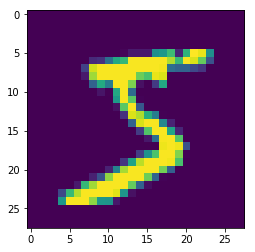

In [139]:
from matplotlib import pyplot as plt
plt.imshow(X_train[0])

In [140]:
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

In [141]:
print(X_train.shape)

(60000, 1, 28, 28)


In [142]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [143]:
print(y_train.shape)

(60000,)


In [144]:
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]


In [145]:
from keras.utils import np_utils
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [146]:
print(Y_train.shape)

(60000, 10)


In [147]:
print(Y_train[:5,:10])

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [148]:
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

In [149]:
K.image_data_format()

'channels_first'

In [150]:
K.set_image_dim_ordering('th')
K.image_data_format()

'channels_first'

In [151]:
model = Sequential()

In [152]:
model.add(InputLayer(input_shape=(1, 28, 28)))

In [153]:
model.add(Conv2D(32, (3, 3), activation='relu'))

In [154]:
print(model.output_shape)

(None, 32, 26, 26)


In [155]:
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [156]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [157]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [158]:
with tf.device('/gpu:0'):
    model.fit(X_train, Y_train, 
          batch_size=32, epochs=10, verbose=2)

Epoch 1/10
26s - loss: 0.2202 - acc: 0.9326
Epoch 2/10
25s - loss: 0.0932 - acc: 0.9720
Epoch 3/10
25s - loss: 0.0685 - acc: 0.9789
Epoch 4/10
25s - loss: 0.0551 - acc: 0.9829
Epoch 5/10
25s - loss: 0.0494 - acc: 0.9847
Epoch 6/10
25s - loss: 0.0442 - acc: 0.9864
Epoch 7/10
25s - loss: 0.0366 - acc: 0.9886
Epoch 8/10
25s - loss: 0.0333 - acc: 0.9893
Epoch 9/10
25s - loss: 0.0328 - acc: 0.9894
Epoch 10/10
25s - loss: 0.0294 - acc: 0.9909


In [159]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 12, 12)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               589952    
__________

In [160]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [161]:
print("Baseline Error: %.2f%%" % (100-score[1]*100))

Baseline Error: 0.83%
